# Dataset Generation

In [1]:
import random
import numpy as np
import json

DATASET_SIZE = 1
OUTPUT_FILE = "demonstrations_with_states.txt"

# Feature Definitions: track location (A,B,C,D) and cut status
ITEMS = ["pot", "pan", "plate", "tomato", "meat", "onion", "mushroom", "lettuce", "egg"]
CUTTABLES = ["tomato", "onion", "mushroom", "lettuce"]
LOCATIONS = ["A", "B", "C", "D"]

class StateTracker:
    def __init__(self):
        self.feature_map = {}
        idx = 0
        self.num = 20
        
        # Location features: e.g., "pot_A": 0, "pot_B": 1...
        for item in ITEMS:
            for loc in LOCATIONS:
                self.feature_map[f"{item}_{loc}"] = idx
                idx += 1
        
        # Cut status features: e.g., "tomato_cut": 36...
        for item in CUTTABLES:
            self.feature_map[f"{item}_cut"] = idx
            idx += 1
        
        # Global status
        self.feature_map["stove_on"] = idx
        self.n_features = idx + 1
        self.reset()
        print("Feature_map: ", self.feature_map)
    
    def reset(self):
        """Reset state to initial conditions (everything at A, raw, stove off)"""
        self.current_state = np.zeros(self.n_features, dtype=int)
        for item in ITEMS:
            self.set_feature(f"{item}_A", 1)
    
    def set_feature(self, key, value):
        if key in self.feature_map:
            self.current_state[self.feature_map[key]] = value
    
    def get_feature(self, key):
        return self.current_state[self.feature_map[key]] if key in self.feature_map else 0
    
    def get_state_vector(self):
        if self.num:
            # print(self.current_state)
            self.num -= 1
        return self.current_state.copy()
    
    def apply_action(self, action_str):
        """Parse action string and update internal state vector"""
        if action_str.startswith("move"):
            # Parse "move (item origin to dest)"
            content = action_str[action_str.find("(")+1 : action_str.find(")")]
            item, origin, _, dest = content.split()
            self.set_feature(f"{item}_{origin}", 0)
            self.set_feature(f"{item}_{dest}", 1)
        elif action_str.startswith("cut"):
            # Parse "cut (item loc)"
            content = action_str[action_str.find("(")+1 : action_str.find(")")]
            item = content.split()[0]
            self.set_feature(f"{item}_cut", 1)
        elif action_str.startswith("turn_on"):
            self.set_feature("stove_on", 1)
        elif action_str.startswith("turn_off"):
            self.set_feature("stove_on", 0)

class RecipeGenerator:
    def __init__(self):
        self.demos = []
        self.tracker = StateTracker()
    
    def _record_trajectory(self, actions):
        """Run actions through state tracker and record (state, action) pairs"""
        self.tracker.reset()
        trajectory = []
        for action in actions:
            state_vector = self.tracker.get_state_vector().tolist()
            trajectory.append({"state": state_vector, "action": action})
            self.tracker.apply_action(action)
        
        final_state_vector = self.tracker.get_state_vector().tolist()
        trajectory.append({"state": final_state_vector, "action": "stop"})
        self.demos.append(trajectory)
    
    # Recipe Definitions
    
    def generate_grilled_steak(self):           return ["move (pan A to C)", "move (meat A to C)", "turn_on (stove C)", "move (plate A to B)", "turn_off (stove C)", "move (meat C to B)", "move (plate B to D)"]
    def generate_salad(self):                   return ["move (lettuce A to B)", "cut (lettuce B)", "move (onion A to B)", "cut (onion B)", "move (plate A to B)", "move (plate B to D)"]
    def generate_burger(self):                  return ["move (pan A to C)", "move (meat A to C)", "turn_on (stove C)", "move (lettuce A to B)", "cut (lettuce B)", "turn_off (stove C)", "move (meat C to B)", "move (plate A to B)", "move (plate B to D)"]
    def generate_boiled_eggs(self):             return ["move (pot A to C)", "move (egg A to C)", "turn_on (stove C)", "turn_off (stove C)", "move (plate A to C)", "move (plate C to D)"]

    def generate_tomato_soup(self):             return ["move (pot A to C)", "move (tomato A to B)", "cut (tomato B)", "move (tomato B to C)", "turn_on (stove C)", "move (plate A to D)", "move (pot C to D)"]
    def generate_mushroom_soup(self):           return ["move (pot A to C)", "move (mushroom A to B)", "cut (mushroom B)", "move (mushroom B to C)", "move (onion A to B)", "cut (onion B)", "move (onion B to C)", "turn_on (stove C)", "move (plate A to D)", "move (pot C to D)"]
    def generate_tomato_onion_soup_1(self):     return ["move (pot A to C)", "move (tomato A to B)", "cut (tomato B)", "move (tomato B to C)", "move (onion A to B)", "cut (onion B)", "move (onion B to C)", "turn_on (stove C)", "move (plate A to D)", "move (pot C to D)"]
    def generate_tomato_onion_soup_2(self):     return ["move (pot A to C)", "move (onion A to B)", "cut (onion B)", "move (onion B to C)", "move (tomato A to B)", "cut (tomato B)", "move (tomato B to C)", "turn_on (stove C)", "move (plate A to D)", "move (pot C to D)"]

    def generate_random_dataset(self, count):
        # available_recipes = [self.generate_tomato_soup, self.generate_grilled_steak, self.generate_mushroom_stew, self.generate_salad, self.generate_burger, self.generate_boiled_eggs]
        available_recipes = [self.generate_tomato_onion_soup_1]
        print(f"Generating {count} state-aware demonstrations...")
        for i in range(count):
            recipe_func = random.choice(available_recipes)
            actions = recipe_func()
            self._record_trajectory(actions)
    
    # def save_to_file(self):
    #     # Save as JSON Lines (each line is a full trajectory object)
    #     with open(OUTPUT_FILE, "w") as f:
    #         for demo in self.demos:
    #             f.write(json.dumps(demo) + "\n")
    #     print(f"Done! Saved {len(self.demos)} trajectories to {OUTPUT_FILE}")
    #     print(f"State Vector Size: {self.tracker.n_features}")

# if __name__ == "__main__":
#     gen = RecipeGenerator()
#     gen.generate_random_dataset(DATASET_SIZE)
#     gen.save_to_file()

# IRL

In [2]:
import numpy as np
import json

def load_demonstrations(filepath):
    """Load demonstrations from JSON file"""
    with open(filepath, 'r') as f:
        demo_lists = [json.loads(line) for line in f.read().strip().split('\n')]
    
    demonstrations = []
    all_actions = set()
    
    for demo in demo_lists:
        trajectory = [(tuple(step['state']), step['action']) for step in demo]
        demonstrations.append(trajectory)
        all_actions.update(step['action'] for step in demo)
    
    return demonstrations, sorted(list(all_actions))

def create_state_action_mappings(demonstrations, unique_actions):
    """Create bidirectional mappings between states/actions and indices"""
    # Collect unique states
    unique_states = set()
    for trajectory in demonstrations:
        unique_states.update(state for state, _ in trajectory)
    
    # Create mappings
    state_to_idx = {state: idx for idx, state in enumerate(sorted(unique_states))}
    idx_to_state = {idx: state for state, idx in state_to_idx.items()}
    action_to_idx = {action: idx for idx, action in enumerate(unique_actions)}
    idx_to_action = {idx: action for action, idx in action_to_idx.items()}
    
    print("state_to_idx:", state_to_idx)
    print("idx_to_state:", idx_to_state)
    print("action_to_idx:", action_to_idx)
    print("idx_to_action:", idx_to_action)
    
    return state_to_idx, idx_to_state, action_to_idx, idx_to_action

def create_feature_matrix(idx_to_state):
    """
    Create task-discriminative features for kitchen environment.
    State vector layout (41 dims):
    - Indices 0-35: Object locations (9 objects × 4 locations)
    - Indices 36-39: Cut status (tomato, onion, mushroom, lettuce)
    - Index 40: Stove on/off
    """
    features = []
    
    for idx in range(len(idx_to_state)):
        state = np.array(idx_to_state[idx])
        feat = []
        
        # Features 0-3: Items at each location
        for loc in range(4):
            feat.append(sum(state[item*4 + loc] for item in range(9)))
        
        feat.append(np.sum(state[36:40]))  # Feature 4: total cut items
        feat.append(state[40])              # Feature 5: stove on
        
        # Discriminative features for different cooking tasks
        pot_at_C, pan_at_C = state[2], state[6]
        feat.append(pot_at_C)               # Feature 6: Pot at stove C
        feat.append(pan_at_C)               # Feature 7: Pan at stove C
        feat.append(state[18])              # Feature 8: Egg at stove C
        
        tomato_cut, tomato_at_C = state[36], state[14]
        feat.append(tomato_cut * tomato_at_C * pot_at_C)  # Feature 9: Tomato cooking
        
        feat.append(state[22] * pan_at_C)   # Feature 10: Meat cooking
        feat.append(state[37])              # Feature 11: Lettuce cut
        feat.append(state[38])              # Feature 12: Onion cut
        feat.append(state[25] + state[29])  # Feature 13: Vegetables at cutting board
        feat.append(state[13])              # Feature 14: Tomato at cutting board
        feat.append(state[40] * (pot_at_C + pan_at_C))  # Feature 15: Cooking active
        feat.append(state[11])              # Feature 16: Plate at serving location
        # Feature 17: Cooked food ready to serve
        feat.append((1 - state[40]) * (pot_at_C + pan_at_C) * (state[18] + tomato_at_C + state[22]))
        
        features.append(feat)
    
    return np.array(features)

def max_entropy_inverse_rl_kitchen(demonstrations, state_to_idx, action_to_idx, feature_matrix,
                                   temperature=2.0, gamma=0.9, n_iterations=100, learning_rate=0.05):
    """Maximum Entropy Inverse RL for sequential kitchen tasks"""
    n_states, n_actions, n_features = len(state_to_idx), len(action_to_idx), feature_matrix.shape[1]
    reward_weights = np.zeros(n_features)
    
    # Compute empirical feature expectations from expert demonstrations
    empirical_feature_expectations = np.zeros(n_features)
    for trajectory in demonstrations:
        discounted_visitation = np.zeros(n_states)
        for t, (state, action) in enumerate(trajectory):
            discounted_visitation[state_to_idx[state]] += (gamma ** t)
        empirical_feature_expectations += discounted_visitation @ feature_matrix
    empirical_feature_expectations /= len(demonstrations)
    
    # Build transition model from demonstrations
    transition_model = {}  # (s_idx, a_idx) -> s_next_idx
    state_action_pairs = set()
    
    for trajectory in demonstrations:
        for i in range(len(trajectory)):
            state, action = trajectory[i]
            s_idx, a_idx = state_to_idx[state], action_to_idx[action]
            state_action_pairs.add((s_idx, a_idx))
            if i < len(trajectory) - 1:
                transition_model[(s_idx, a_idx)] = state_to_idx[trajectory[i + 1][0]]
    
    print(f"\nFound {len(state_action_pairs)} unique (state, action) pairs")
    print(f"Empirical feature expectation norm: {np.linalg.norm(empirical_feature_expectations):.4f}")
    
    # Gradient descent with adaptive learning rate
    best_diff = float('inf')
    patience = 0
    best_weights = reward_weights.copy()
    momentum = np.zeros(n_features)
    momentum_beta = 0.9
    
    for iteration in range(n_iterations):
        current_lr = learning_rate * (0.95 ** (patience // 5))
        rewards = feature_matrix @ reward_weights
        
        # Backward value iteration
        q_values = {}  # (s_idx, a_idx) -> Q-value
        values = rewards.copy()
        
        for _ in range(30):
            new_values = rewards.copy()
            
            # Update Q-values
            for (s_idx, a_idx) in state_action_pairs:
                if (s_idx, a_idx) in transition_model:
                    q_values[(s_idx, a_idx)] = rewards[s_idx] + gamma * values[transition_model[(s_idx, a_idx)]]
                else:
                    q_values[(s_idx, a_idx)] = rewards[s_idx]  # Terminal action
            
            # Update values using soft-max
            for s_idx in range(n_states):
                available_qs = [q_values[(s_idx, a_idx)] for a_idx in range(n_actions) if (s_idx, a_idx) in q_values]
                if available_qs:
                    available_qs = np.array(available_qs)
                    max_q = np.max(available_qs)
                    new_values[s_idx] = max_q + temperature * np.log(np.sum(np.exp((available_qs - max_q) / temperature)))
            
            if np.max(np.abs(new_values - values)) < 1e-6:
                break
            values = new_values
        
        # Compute soft policy from Q-values
        policy = {}
        for s_idx in range(n_states):
            state_qs = [(a_idx, q_values[(s_idx, a_idx)]) for a_idx in range(n_actions) if (s_idx, a_idx) in q_values]
            if state_qs:
                state_actions, state_q_vals = zip(*state_qs)
                state_q_vals = np.array(state_q_vals)
                max_q = np.max(state_q_vals)
                probs = np.exp((state_q_vals - max_q) / temperature)
                probs /= np.sum(probs)
                for a_idx, prob in zip(state_actions, probs):
                    policy[(s_idx, a_idx)] = prob
        
        # Monte Carlo estimation of expected feature counts
        expected_feature_counts = np.zeros(n_features)
        for _ in range(100):  # Sample 100 trajectories
            s_idx = state_to_idx[demonstrations[np.random.randint(len(demonstrations))][0][0]]
            traj_features = np.zeros(n_features)
            
            for t in range(20):  # Max trajectory length
                traj_features += (gamma ** t) * feature_matrix[s_idx]
                
                # Sample action according to policy
                available = [(a_idx, policy[(s_idx, a_idx)]) for a_idx in range(n_actions) if (s_idx, a_idx) in policy]
                if not available:
                    break
                
                actions, probs = zip(*available)
                probs = np.array(probs) / np.sum(probs)
                a_idx = np.random.choice(actions, p=probs)
                
                if (s_idx, a_idx) not in transition_model:
                    break
                s_idx = transition_model[(s_idx, a_idx)]
            
            expected_feature_counts += traj_features
        expected_feature_counts /= 100
        
        # Gradient update with momentum
        gradient = empirical_feature_expectations - expected_feature_counts
        gradient -= 0.01 * reward_weights  # L2 regularization
        grad_norm = np.linalg.norm(gradient)
        
        momentum = momentum_beta * momentum + (1 - momentum_beta) * gradient
        reward_weights += current_lr * momentum
        
        # Track best solution
        if grad_norm < best_diff:
            best_diff = grad_norm
            best_weights = reward_weights.copy()
            patience = 0
        else:
            patience += 1
        
        if iteration % 10 == 0:
            print(f"Iteration {iteration}: Gradient norm = {grad_norm:.6f}, "
                  f"Reward range = [{np.min(reward_weights):.2f}, {np.max(reward_weights):.2f}], "
                  f"Best = {best_diff:.6f}, LR = {current_lr:.4f}")
        
        if grad_norm < 0.01 or patience > 20:
            print(f"Converged at iteration {iteration}")
            break
    
    print(f"\nFinal best gradient norm: {best_diff:.6f}")
    recovered_rewards = feature_matrix @ best_weights
    return best_weights, recovered_rewards

def predict_action(state, reward_weights, feature_matrix, state_to_idx, action_to_idx,
                  idx_to_action, transition_model, temperature=2.0, gamma=0.9):
    """Predict most likely action from a given state"""
    if state not in state_to_idx:
        print(f"Warning: State not seen during training")
        return None, {}
    
    s_idx = state_to_idx[state]
    rewards = feature_matrix @ reward_weights
    
    # Compute Q-values for all valid actions
    valid_actions = []
    q_values_list = []
    
    for a_idx in range(len(action_to_idx)):
        if (s_idx, a_idx) in transition_model:
            s_next_idx = transition_model[(s_idx, a_idx)]
            q_value = rewards[s_idx] + gamma * rewards[s_next_idx]
            valid_actions.append(a_idx)
            q_values_list.append(q_value)
    
    if not valid_actions:
        print(f"Warning: No valid actions from this state!")
        return None, {}
    
    # Compute softmax policy
    q_values_array = np.array(q_values_list)
    max_q = np.max(q_values_array)
    action_probs_array = np.exp((q_values_array - max_q) / temperature)
    action_probs_array /= np.sum(action_probs_array)
    
    # Create action probability dictionary
    action_probs = {idx_to_action[a_idx]: prob for a_idx, prob in zip(valid_actions, action_probs_array)}
    
    # Get most likely action
    best_action_idx = valid_actions[np.argmax(action_probs_array)]
    predicted_action = idx_to_action[best_action_idx]
    
    return predicted_action, action_probs

# # Main execution
# if __name__ == "__main__":
#     # Load demonstrations
#     demonstrations, unique_actions = load_demonstrations('demonstrations_with_states.txt')
#     print(f"Loaded {len(demonstrations)} demonstrations")
#     print(f"Number of unique actions: {len(unique_actions)}")
#     print(f"Actions: {unique_actions[:5]}...")
    
#     # Create mappings
#     state_to_idx, idx_to_state, action_to_idx, idx_to_action = create_state_action_mappings(demonstrations, unique_actions)
#     # print(f"Number of unique states: {len(state_to_idx)}")
    
#     # Build transition model
#     transition_model = {}
#     for trajectory in demonstrations:
#         for i in range(len(trajectory)):
#             state, action = trajectory[i]
#             s_idx, a_idx = state_to_idx[state], action_to_idx[action]
#             if i < len(trajectory) - 1: transition_model[(s_idx, a_idx)] = state_to_idx[trajectory[i + 1][0]]
    
#     # Create feature matrix
#     feature_matrix = create_feature_matrix(idx_to_state)
#     print(f"Feature matrix shape: {feature_matrix.shape}")
    
#     # Run IRL
#     print("\nRunning Maximum Entropy IRL...")
#     reward_weights, recovered_rewards = max_entropy_inverse_rl_kitchen(
#         demonstrations=demonstrations,
#         state_to_idx=state_to_idx,
#         action_to_idx=action_to_idx,
#         feature_matrix=feature_matrix,
#         temperature=1.0,
#         gamma=0.95,
#         n_iterations=100,
#         learning_rate=0.01
#     )
    
#     print("\n=== Results ===")
#     print(f"Learned reward weights shape: {reward_weights.shape}")
#     print(f"Reward weight statistics:")
#     print(f"  Mean: {np.mean(reward_weights):.4f}")
#     print(f"  Std: {np.std(reward_weights):.4f}")
#     print(f"  Min: {np.min(reward_weights):.4f}")
#     print(f"  Max: {np.max(reward_weights):.4f}")
    
#     print(f"\nRecovered rewards statistics:")
#     print(f"  Mean: {np.mean(recovered_rewards):.4f}")
#     print(f"  Std: {np.std(recovered_rewards):.4f}")
#     print(f"  Min: {np.min(recovered_rewards):.4f}")
#     print(f"  Max: {np.max(recovered_rewards):.4f}")

# Adaptive IRL - Train on One Recipe, Test on Another

In [3]:
# Helper function to test a single demonstration
def test_demonstration(test_demo, reward_weights, feature_matrix, state_to_idx, action_to_idx, idx_to_action, transition_model):
    """Test predictions on a single demonstration and return results"""
    total, correct = 0, 0
    step_results = []

    
    for i in range(len(test_demo) - 1):  # Exclude last state (stop action)
        state, expert_action = test_demo[i]
        # Predict action
        predicted_action, _ = predict_action(state, reward_weights, feature_matrix, state_to_idx, action_to_idx, idx_to_action, transition_model)
        if predicted_action is None:
            predicted_action = "<UNSEEN_STATE>"
            is_correct = False
        else: is_correct = (predicted_action == expert_action)
        # is_correct = (predicted_action == expert_action)
        status = "✓" if is_correct else "✗"
        
        print(f"  Step {i+1}: Expert={expert_action:30s} Predicted={predicted_action:30s} {status}")
        
        step_results.append({'step': i+1, 'correct': is_correct})
        total += 1
        if is_correct: correct += 1
    
    accuracy = correct / total if total > 0 else 0
    return accuracy, correct, total, step_results

In [4]:
# Generate separate training and test datasets
print("GENERATING TRAINING DATA (Recipe 1: Tomato first)")
gen_train = RecipeGenerator()
for i in range(3):  # num demonstrations of recipe 1
    actions = gen_train.generate_tomato_onion_soup_1()
    gen_train._record_trajectory(actions)
# Save training data
with open("train_demos.txt", "w") as f:
    for demo in gen_train.demos: f.write(json.dumps(demo) + "\n")


print("GENERATING TEST DATA (Recipe 2: Onion first)")
gen_test = RecipeGenerator()
for i in range(2):  # num demonstrations of recipe 2
    actions = gen_test.generate_tomato_onion_soup_2()
    gen_test._record_trajectory(actions)
print("GENERATING TEST DATA (Recipe 3: Mushroom)")
for i in range(2):  # num demonstrations of recipe 2
    actions = gen_test.generate_mushroom_soup()
    gen_test._record_trajectory(actions)
print("GENERATING TEST DATA (Recipe 4: Just tomato)")
for i in range(2):  # num demonstrations of recipe 2
    actions = gen_test.generate_tomato_soup()
    gen_test._record_trajectory(actions)
# Save test data
with open("test_demos.txt", "w") as f:
    for demo in gen_test.demos: f.write(json.dumps(demo) + "\n")

GENERATING TRAINING DATA (Recipe 1: Tomato first)
Feature_map:  {'pot_A': 0, 'pot_B': 1, 'pot_C': 2, 'pot_D': 3, 'pan_A': 4, 'pan_B': 5, 'pan_C': 6, 'pan_D': 7, 'plate_A': 8, 'plate_B': 9, 'plate_C': 10, 'plate_D': 11, 'tomato_A': 12, 'tomato_B': 13, 'tomato_C': 14, 'tomato_D': 15, 'meat_A': 16, 'meat_B': 17, 'meat_C': 18, 'meat_D': 19, 'onion_A': 20, 'onion_B': 21, 'onion_C': 22, 'onion_D': 23, 'mushroom_A': 24, 'mushroom_B': 25, 'mushroom_C': 26, 'mushroom_D': 27, 'lettuce_A': 28, 'lettuce_B': 29, 'lettuce_C': 30, 'lettuce_D': 31, 'egg_A': 32, 'egg_B': 33, 'egg_C': 34, 'egg_D': 35, 'tomato_cut': 36, 'onion_cut': 37, 'mushroom_cut': 38, 'lettuce_cut': 39, 'stove_on': 40}
GENERATING TEST DATA (Recipe 2: Onion first)
Feature_map:  {'pot_A': 0, 'pot_B': 1, 'pot_C': 2, 'pot_D': 3, 'pan_A': 4, 'pan_B': 5, 'pan_C': 6, 'pan_D': 7, 'plate_A': 8, 'plate_B': 9, 'plate_C': 10, 'plate_D': 11, 'tomato_A': 12, 'tomato_B': 13, 'tomato_C': 14, 'tomato_D': 15, 'meat_A': 16, 'meat_B': 17, 'meat_C': 18,

In [5]:
# INITIAL TRAINING on Recipe 1 only
print("INITIAL TRAINING: Learning from 1 recipe only")
# Load training demonstrations
train_demonstrations, train_actions = load_demonstrations('train_demos.txt')
print(f"Loaded {len(train_demonstrations)} training demonstrations\n")

# Create mappings
state_to_idx, idx_to_state, action_to_idx, idx_to_action = create_state_action_mappings(train_demonstrations, train_actions)

# Build transition model
transition_model = {}
for trajectory in train_demonstrations:
    for i in range(len(trajectory)):
        state, action = trajectory[i]
        s_idx, a_idx = state_to_idx[state], action_to_idx[action]
        if i < len(trajectory) - 1: transition_model[(s_idx, a_idx)] = state_to_idx[trajectory[i + 1][0]]

# Create feature matrix
feature_matrix = create_feature_matrix(idx_to_state)
print(f"\nFeature matrix shape: {feature_matrix.shape}")

# Run IRL
print("\nRunning IRL...")
reward_weights, recovered_rewards = max_entropy_inverse_rl_kitchen(
    demonstrations=train_demonstrations,
    state_to_idx=state_to_idx,
    action_to_idx=action_to_idx,
    feature_matrix=feature_matrix,
    temperature=1.0,
    gamma=0.95,
    n_iterations=100,
    learning_rate=0.01
)
print(f"\nInitial training complete!\n")

INITIAL TRAINING: Learning from 1 recipe only
Loaded 3 training demonstrations

state_to_idx: {(0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1): 0, (0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1): 1, (0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0): 2, (0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1): 3, (0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0): 4, (0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0): 5, (0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0): 6, (0, 0, 1,

In [6]:
# ADAPTIVE IRL: Test on Recipe 2, then retrain
print("ADAPTIVE IRL LOOP")
# Load test demonstrations
test_demonstrations, _ = load_demonstrations('test_demos.txt')
# Keep track of all training data
all_training_data = train_demonstrations.copy()
test_history = []

# Process each test demonstration
for test_num, test_demo in enumerate(test_demonstrations, 1):
    print(f"TEST {test_num}/{len(test_demonstrations)}: Evaluating Unseen Recipe Demo")

    # Test with current model
    accuracy, correct, total, step_results = test_demonstration(
        test_demo, reward_weights, feature_matrix, state_to_idx,
        action_to_idx, idx_to_action, transition_model)
    print(f"\nTest Accuracy: {accuracy:.1%} ({correct}/{total} correct predictions)")
    # Record results
    test_history.append({
        'test_num': test_num,   'accuracy': accuracy,   'correct': correct,
        'total': total,         'training_size_before': len(all_training_data)})    
    # Add test demo to training data
    print(f"\n>>> Adding test demonstration to training set...")
    all_training_data.append(test_demo)
    print(f">>> Training set size: {len(train_demonstrations)} → {len(all_training_data)}")


    # Recreate mappings (may have new states/actions)
    unique_actions_new = set()
    for traj in all_training_data: unique_actions_new.update(action for _, action in traj)
    unique_actions_new = sorted(list(unique_actions_new))
    state_to_idx, idx_to_state, action_to_idx, idx_to_action = create_state_action_mappings(all_training_data, unique_actions_new)
    # Rebuild transition model
    transition_model = {}
    for trajectory in all_training_data:
        for i in range(len(trajectory)):
            state, action = trajectory[i]
            s_idx, a_idx = state_to_idx[state], action_to_idx[action]
            if i < len(trajectory) - 1: transition_model[(s_idx, a_idx)] = state_to_idx[trajectory[i + 1][0]]
    # Rebuild feature matrix
    feature_matrix = create_feature_matrix(idx_to_state)
    print(f"States: {len(state_to_idx)}, Actions: {len(action_to_idx)}, Features: {feature_matrix.shape[1]}")
    
    # Run IRL
    reward_weights, recovered_rewards = max_entropy_inverse_rl_kitchen(
        demonstrations=all_training_data,   state_to_idx=state_to_idx,      action_to_idx=action_to_idx,
        feature_matrix=feature_matrix,      temperature=1.0,gamma=0.95,     n_iterations=100,   learning_rate=0.01)
    print(f"\nRetraining complete. Model updated with {len(all_training_data)} total demonstrations.\n")

ADAPTIVE IRL LOOP
TEST 1/6: Evaluating Unseen Recipe Demo
  Step 1: Expert=move (pot A to C)              Predicted=move (pot A to C)              ✓
  Step 2: Expert=move (onion A to B)            Predicted=move (tomato A to B)           ✗
  Step 3: Expert=cut (onion B)                  Predicted=<UNSEEN_STATE>                 ✗
  Step 4: Expert=move (onion B to C)            Predicted=<UNSEEN_STATE>                 ✗
  Step 5: Expert=move (tomato A to B)           Predicted=<UNSEEN_STATE>                 ✗
  Step 6: Expert=cut (tomato B)                 Predicted=<UNSEEN_STATE>                 ✗
  Step 7: Expert=move (tomato B to C)           Predicted=<UNSEEN_STATE>                 ✗
  Step 8: Expert=turn_on (stove C)              Predicted=turn_on (stove C)              ✓
  Step 9: Expert=move (plate A to D)            Predicted=move (plate A to D)            ✓
  Step 10: Expert=move (pot C to D)              Predicted=move (pot C to D)              ✓

Test Accuracy: 40.0% (4/10 cor

In [7]:
# Example 2: Test first 6 steps of first 3 trajectories
l = len(all_training_data)
for i in range(l):
    print(i)
    le = len(all_training_data[i])
    for j in range(le):
        state = all_training_data[i][j][0]
        action, probs = predict_action(state, reward_weights, feature_matrix,
                                      state_to_idx, action_to_idx, idx_to_action, transition_model)
        print(f"Actual: {all_training_data[i][j][1]} \n Predicted: {action} \n")
    print('\n\n')

0
Actual: move (pot A to C) 
 Predicted: move (pot A to C) 

Actual: move (tomato A to B) 
 Predicted: move (tomato A to B) 

Actual: cut (tomato B) 
 Predicted: cut (tomato B) 

Actual: move (tomato B to C) 
 Predicted: move (tomato B to C) 

Actual: move (onion A to B) 
 Predicted: move (onion A to B) 

Actual: cut (onion B) 
 Predicted: cut (onion B) 

Actual: move (onion B to C) 
 Predicted: move (onion B to C) 

Actual: turn_on (stove C) 
 Predicted: turn_on (stove C) 

Actual: move (plate A to D) 
 Predicted: move (plate A to D) 

Actual: move (pot C to D) 
 Predicted: move (pot C to D) 

Actual: stop 
 Predicted: None 




1
Actual: move (pot A to C) 
 Predicted: move (pot A to C) 

Actual: move (tomato A to B) 
 Predicted: move (tomato A to B) 

Actual: cut (tomato B) 
 Predicted: cut (tomato B) 

Actual: move (tomato B to C) 
 Predicted: move (tomato B to C) 

Actual: move (onion A to B) 
 Predicted: move (onion A to B) 

Actual: cut (onion B) 
 Predicted: cut (onion B) 

Actu

In [ ]:
# Summary of Adaptive Learning
print("\n" + "=" * 70)
print("ADAPTIVE LEARNING SUMMARY")
print("=" * 70)
print(f"Initial training: {len(train_demonstrations)} demos (Recipe 1 only)")
print(f"Final training: {len(all_training_data)} demos (Recipe 1 + Recipe 2)")
print(f"Tests conducted: {len(test_history)}\n")

print("Test-by-test results:")
print(f"{'Test':<8} {'Train Size':<12} {'Accuracy':<12} {'Correct/Total':<15}")
print("-" * 70)
for result in test_history:
    print(f"{result['test_num']:<8} {result['training_size_before']:<12} "
          f"{result['accuracy']:>6.1%}{'':5} {result['correct']}/{result['total']}")

if test_history:
    avg_accuracy = np.mean([r['accuracy'] for r in test_history])
    print(f"\nAverage accuracy across tests: {avg_accuracy:.1%}")
    
    if len(test_history) > 1:
        improvement = test_history[-1]['accuracy'] - test_history[0]['accuracy']
        print(f"Accuracy improvement (Test 1 → Test {len(test_history)}): {improvement:+.1%}")

print("Key Insight: Model learned to handle BOTH recipe orderings!")


ADAPTIVE LEARNING SUMMARY
Initial training: 3 demos (Recipe 1 only)
Final training: 9 demos (Recipe 1 + Recipe 2)
Tests conducted: 6

Test-by-test results:
Test     Train Size   Accuracy     Correct/Total  
----------------------------------------------------------------------
1        3             40.0%      4/10
2        4             90.0%      9/10
3        5             10.0%      1/10
4        6             90.0%      9/10
5        7             57.1%      4/7
6        8            100.0%      7/7

Average accuracy across tests: 64.5%
Accuracy improvement (Test 1 → Test 6): +60.0%

Key Insight: Model learned to handle BOTH recipe orderings!


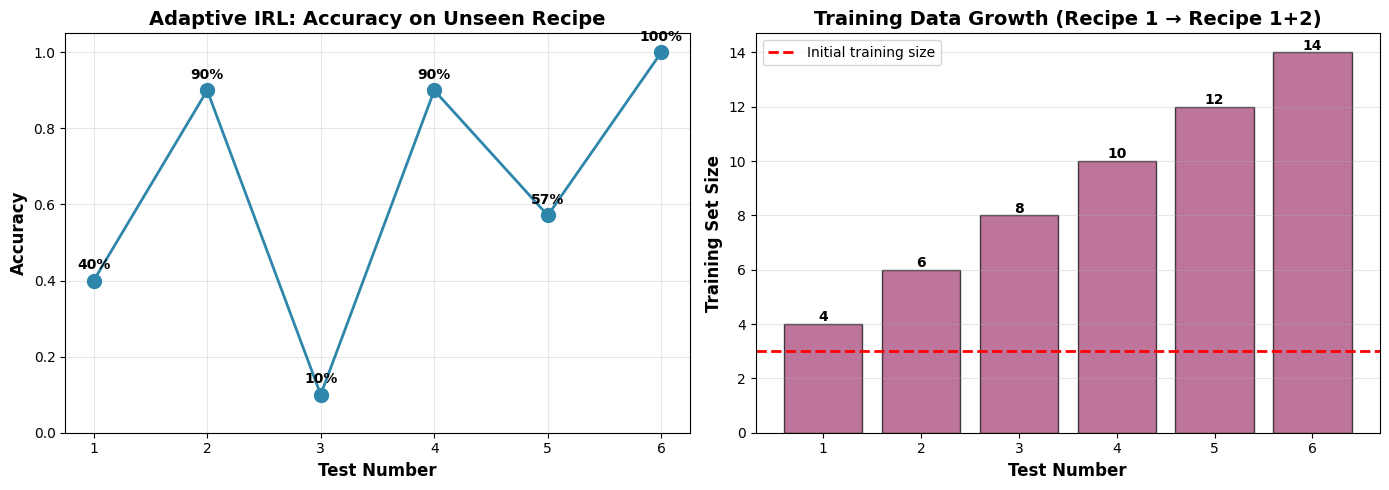


Visualization complete!


In [9]:
# Optional: Visualize learning progress
import matplotlib.pyplot as plt

if test_history:
    test_nums = [r['test_num'] for r in test_history]
    accuracies = [r['accuracy'] for r in test_history]
    train_sizes = [r['training_size_before'] + r['test_num'] for r in test_history]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Accuracy over tests
    ax1.plot(test_nums, accuracies, marker='o', linewidth=2, markersize=10, color='#2E86AB')
    ax1.set_xlabel('Test Number', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    ax1.set_title('Adaptive IRL: Accuracy on Unseen Recipe', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1.05)
    for x, y in zip(test_nums, accuracies):
        ax1.text(x, y + 0.03, f'{y:.0%}', ha='center', fontsize=10, fontweight='bold')
    
    # Plot 2: Training set growth
    ax2.bar(test_nums, train_sizes, color='#A23B72', alpha=0.7, edgecolor='black')
    ax2.axhline(y=len(train_demonstrations), color='red', linestyle='--', label='Initial training size', linewidth=2)
    ax2.set_xlabel('Test Number', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Training Set Size', fontsize=12, fontweight='bold')
    ax2.set_title('Training Data Growth (Recipe 1 → Recipe 1+2)', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.legend()
    for x, y in zip(test_nums, train_sizes):
        ax2.text(x, y + 0.1, f'{y}', ha='center', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("\nVisualization complete!")